## RQ3 - Are there biases induced by the evaluation of open ended questions ?

# Features 

In [3]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/data/Lernnavi' #You many change the directory
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Features per Dimension 

- Effort        ->  weekly_clicks, weekly_time_spent
- Consistency   ->  mean_session_duration, std_weekly_activity
- Regularity    ->  mean_days_between_sessions
- Proactivity   ->  go_to_theory_actions, early_sessions
- Control       ->  weekly_next_actions, weekly_skip_actions
- Assessment     ->  weekly_percentage_correct, challenges_completed

is_active
False    20557
True      1913
Name: count, dtype: int64


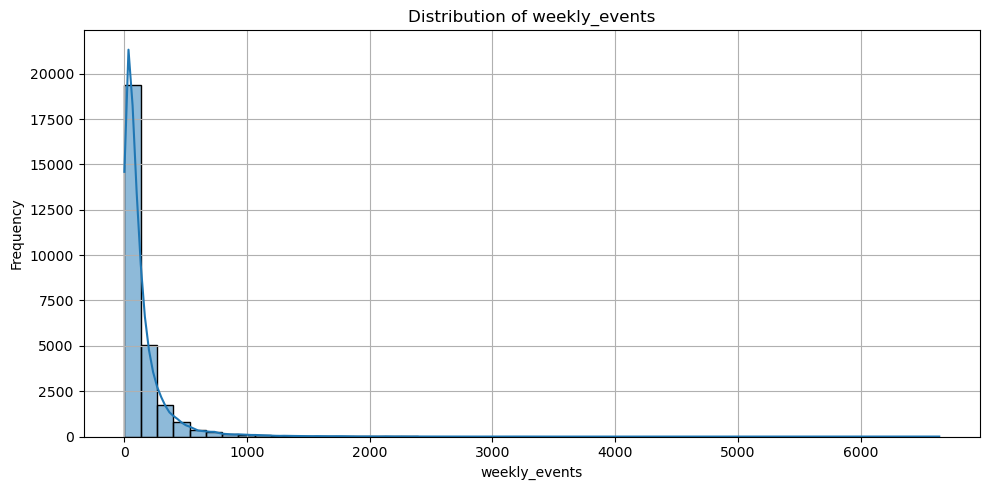

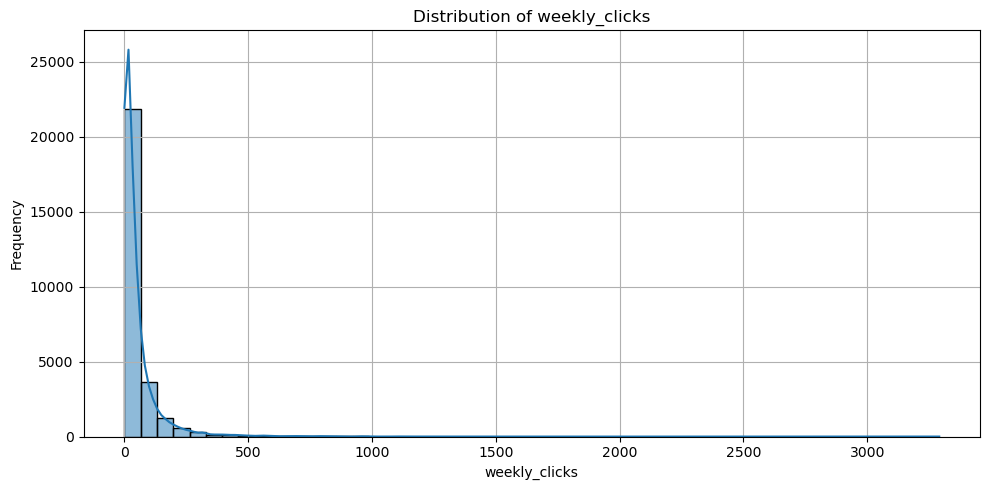

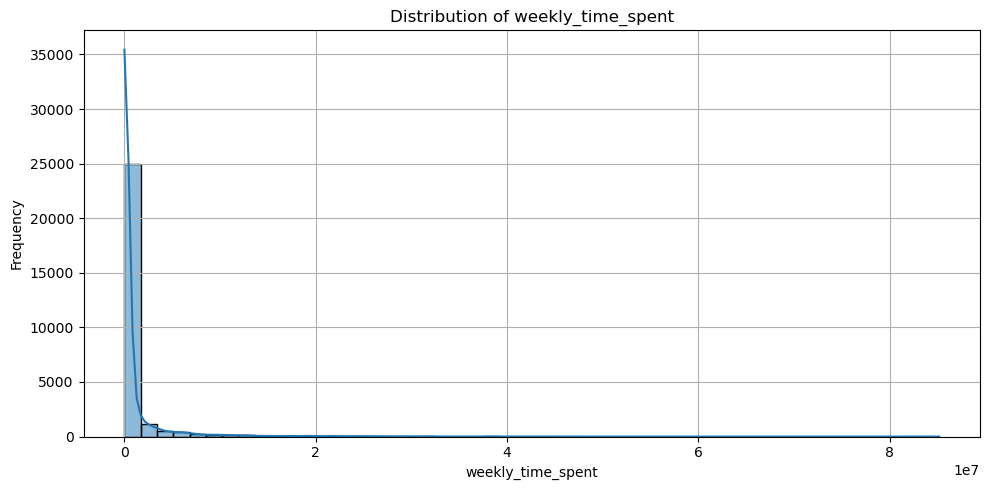

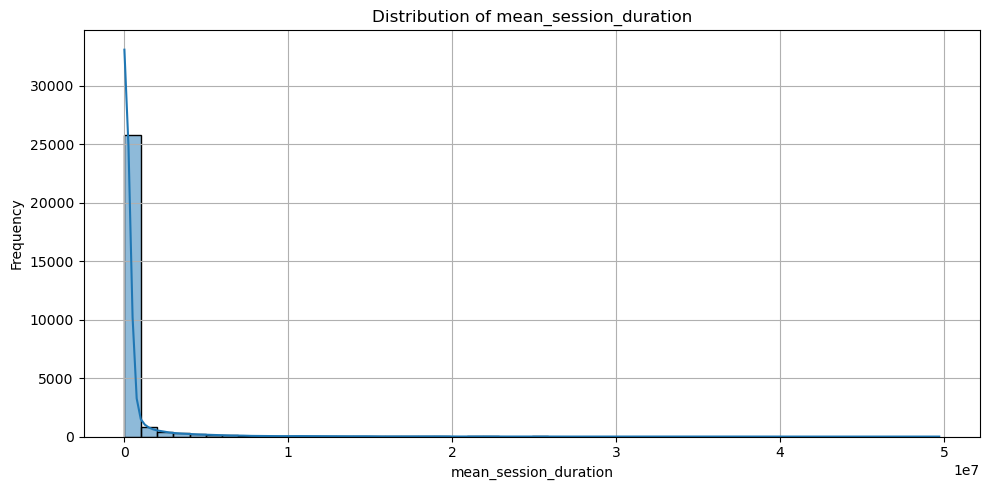

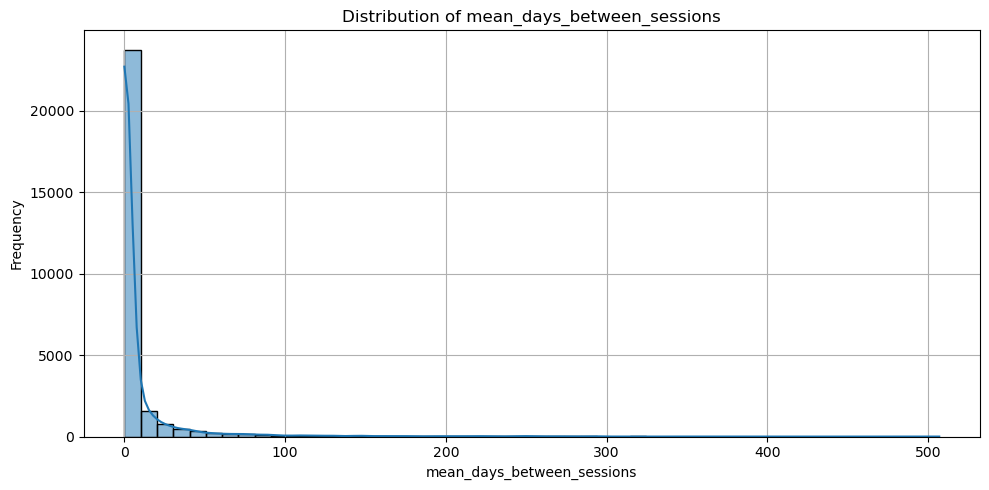

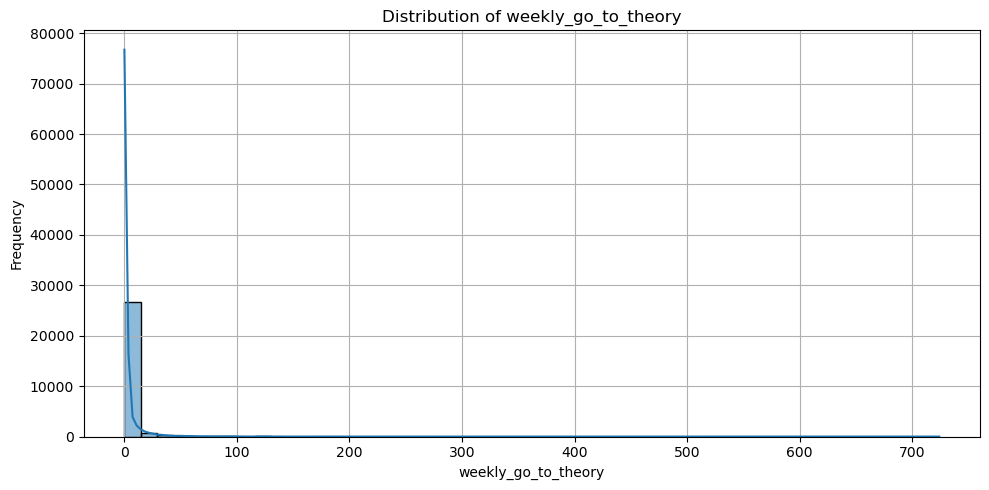

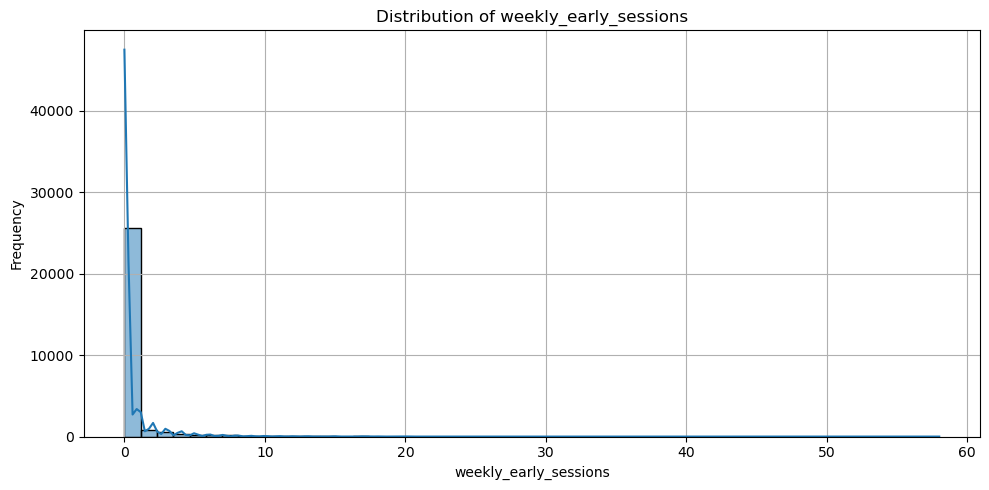

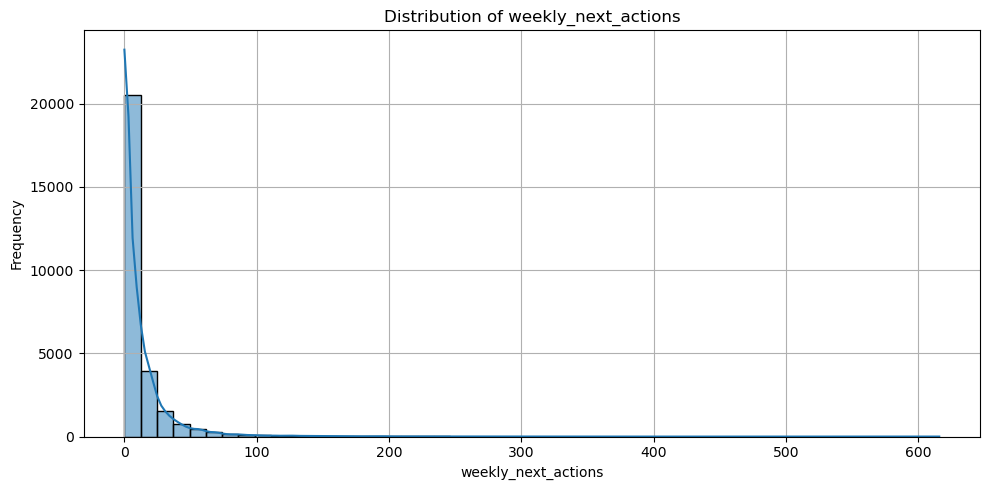

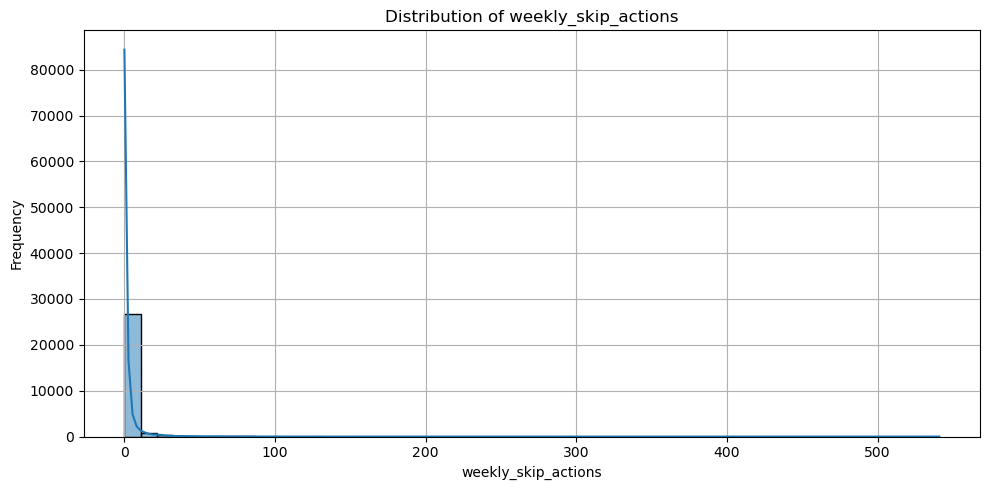

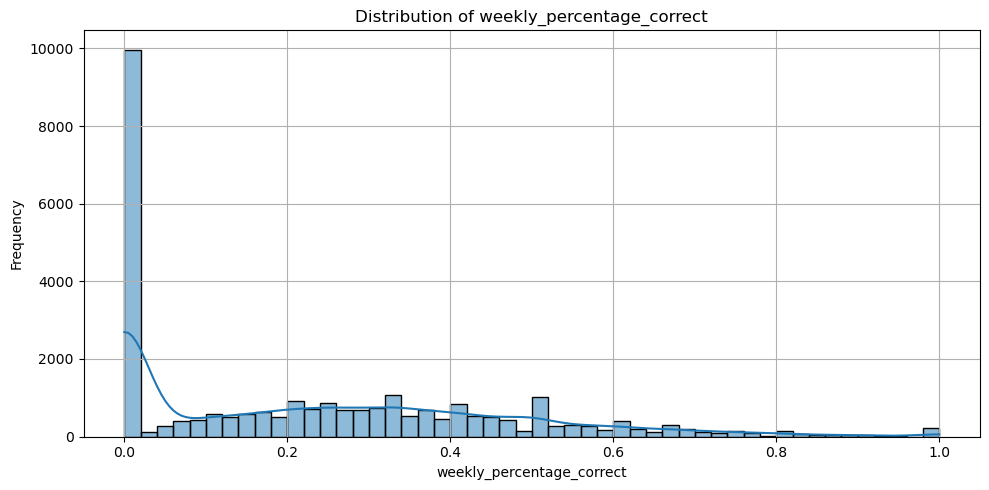

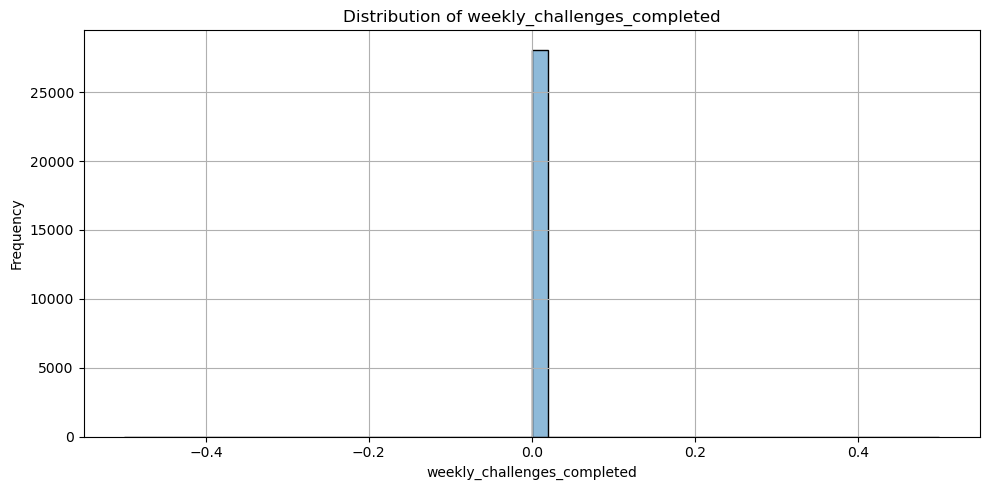

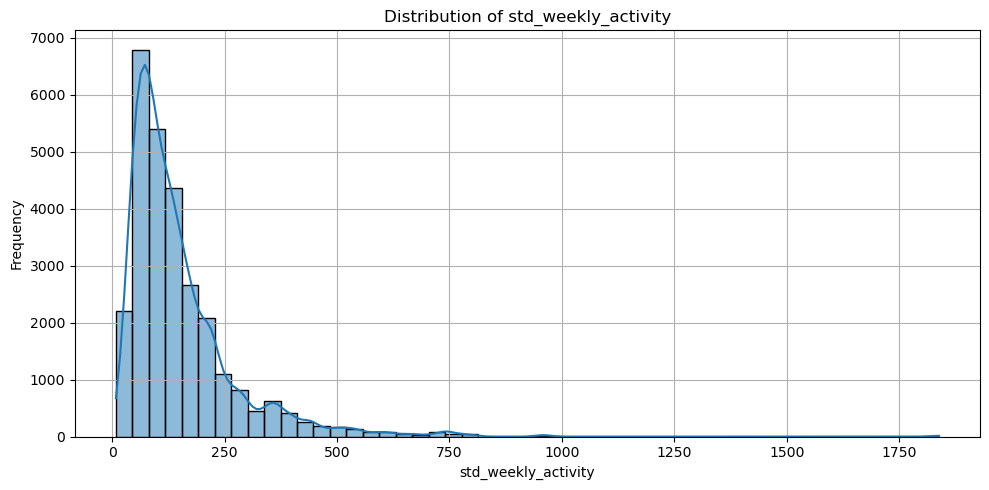

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event_date and start_time to datetime
events['date'] = pd.to_datetime(events['event_date'])
transactions['date'] = pd.to_datetime(transactions['start_time'])

# Extract year and week number
events['year_week'] = events['date'].dt.strftime('%Y-%U')
transactions['year_week'] = transactions['date'].dt.strftime('%Y-%U')

# Effort
weekly_events = events.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_events')
weekly_clicks = events[events['event_type'] == 'CLICK'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_clicks')

# Time spent per session
events = events.sort_values(by=['user_id', 'date'])
events['next_date'] = events.groupby(['user_id', 'session_id'])['date'].shift(-1)
events['session_time'] = (events['next_date'] - events['date']).dt.total_seconds()
weekly_time_spent = events.groupby(['user_id', 'year_week'])['session_time'].sum().reset_index(name='weekly_time_spent')

# Consistency
session_durations = events.groupby(['user_id', 'session_id']).agg(
    session_start=('date', 'min'),
    session_end=('date', 'max')
).reset_index()
session_durations['duration'] = (session_durations['session_end'] - session_durations['session_start']).dt.total_seconds()
session_durations['year_week'] = session_durations['session_start'].dt.strftime('%Y-%U')
mean_session_duration = session_durations.groupby(['user_id', 'year_week'])['duration'].mean().reset_index(name='mean_session_duration')

std_weekly_activity = weekly_events.groupby('user_id')['weekly_events'].std().reset_index(name='std_weekly_activity')

# Regularity
session_starts = events.groupby(['user_id', 'session_id'])['date'].min().reset_index()
session_starts = session_starts.sort_values(by=['user_id', 'date'])
session_starts['previous_session'] = session_starts.groupby('user_id')['date'].shift(1)
session_starts['days_between'] = (session_starts['date'] - session_starts['previous_session']).dt.days
session_starts['year_week'] = session_starts['date'].dt.strftime('%Y-%U')
mean_days_between_sessions = session_starts.groupby(['user_id', 'year_week'])['days_between'].mean().reset_index(name='mean_days_between_sessions')

# Proactivity
go_to_theory_actions = events[events['action'] == 'GO_TO_THEORY'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_go_to_theory')
events['hour'] = events['date'].dt.hour
early_sessions = events[events['hour'] < 8].groupby(['user_id', 'year_week'])['session_id'].nunique().reset_index(name='weekly_early_sessions')

# Control
next_actions = events[events['action'] == 'NEXT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_next_actions')
skip_actions = events[events['action'] == 'SKIP'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_skip_actions')

# Assessment
correct_evaluations = transactions[transactions['evaluation'] == 'CORRECT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_correct')
total_evaluations = transactions.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_total')
assessment = pd.merge(total_evaluations, correct_evaluations, on=['user_id', 'year_week'], how='left').fillna(0)
assessment['weekly_percentage_correct'] = assessment['weekly_correct'] / assessment['weekly_total']

challenges_completed = transactions[transactions['challenge_id'].notnull() & (transactions['session_accepted'] == 1)].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_challenges_completed')

# Combine all features
user_week_features = pd.DataFrame(events[['user_id', 'year_week']].drop_duplicates())

feature_dfs = [
    weekly_events, weekly_clicks, weekly_time_spent, mean_session_duration,
    mean_days_between_sessions, go_to_theory_actions,
    early_sessions, next_actions, skip_actions,
    assessment[['user_id', 'year_week', 'weekly_percentage_correct']], challenges_completed
]

for feature_df in feature_dfs:
    user_week_features = pd.merge(user_week_features, feature_df, on=['user_id', 'year_week'], how='left')

# Fill missing values with 0
user_week_features = user_week_features.fillna(0)

user_week_features = pd.merge(user_week_features, std_weekly_activity, on='user_id', how='left')


# -------------------------------------------------------------------
# 1.  total events per user
total_events = events.groupby('user_id').size().rename('n_events')

# 2.  active weeks per user  (we already have weekly_events)
active_weeks = weekly_events.groupby('user_id').size().rename('n_weeks')

# 3.  merge the two summaries
activity_summary = pd.concat([total_events, active_weeks], axis=1).fillna(0)

# 4.  flag "active" learners
activity_summary['is_active'] = (
        (activity_summary['n_events'] >= 10) &
        (activity_summary['n_weeks']  >= 10)
)

print(activity_summary['is_active'].value_counts())

# 1.  keep only active user_ids
active_ids = activity_summary.index[activity_summary['is_active']]

events        = events[events['user_id'].isin(active_ids)]
transactions  = transactions[transactions['user_id'].isin(active_ids)]

# 2.  because user_week_features is built *after* events filtering,
#     you can now rerun the feature-engineering cell OR
#     just filter the existing DF:
user_week_features = user_week_features[user_week_features['user_id'].isin(active_ids)]

# Visualize the features
numeric_cols = user_week_features.select_dtypes(include=['number']).columns.drop('user_id', errors='ignore')

for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(user_week_features[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Create correlation matrix to visualize relationships between features    #


In [5]:
user_week_features.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity
0,387604,2021-20,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
1,387604,2021-21,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
2,387604,2021-25,7,4.0,7.837221e+05,7.837424e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
3,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.0,0.0,0.0,0.0,7.0,0.0,0.0,141.95107
4,387604,2021-31,12,6.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107


In [6]:
user_week_features.to_csv("../../data/user_week_features.csv", index=False)


In [7]:
user_week_features['week_start'] = pd.to_datetime(
        user_week_features['year_week'] + '-0',   # '-0' = Sunday
        format='%Y-%U-%w'
)
user_week_features['week_period'] = user_week_features['week_start'].dt.to_period('W-SUN')

In [8]:
# Build the year-week string in events  ------------------------------
events['year_week'] = (
    pd.to_datetime(events['event_date'])
      .dt.strftime('%Y-%U')     # <-- .dt before strftime
)

# Same idea for transactions if you need it
transactions['year_week'] = (
    pd.to_datetime(transactions['start_time'])
      .dt.strftime('%Y-%U')
)


In [9]:

meaningful = events.query(
    "action in ['SUBMIT_ANSWER','REVIEW_TASK','NEXT','SKIP','GO_TO_THEORY']"
).copy()

meaningful['iso_week'] = pd.to_datetime(meaningful['event_date']).dt.to_period('W')

# ---------- 2  any-activity table ------------------------------------
has_activity = (meaningful
                .drop_duplicates(['user_id','iso_week'])
                .assign(active=1))

# ---------- 3  build next-week target --------------------------------
# left df = current week, right df = next week
target_df = (has_activity
             .merge(has_activity.assign(iso_week=lambda d: d['iso_week']-1),
                    on=['user_id','iso_week'],
                    how='left', suffixes=('','_next'))
             .rename(columns={'active_next':'engaged_next_week'})
             .fillna({'engaged_next_week':0})
             .loc[:, ['user_id','iso_week','engaged_next_week']])

target_df['year_week'] = (
        target_df['iso_week']          # Period[W-SUN]
                 .astype('datetime64[ns]')
                 .dt.strftime('%Y-%U') )

# ---------- 4  attach to your feature table --------------------------
user_week_features = (user_week_features
                      .merge(target_df[['user_id','year_week','engaged_next_week']],
                             on=['user_id','year_week'],
                             how='left'))

# rows with NaN in label = last observed week for that user
user_week_features = user_week_features.dropna(subset=['engaged_next_week'])
user_week_features['engaged_next_week'] = (
    user_week_features['engaged_next_week'].astype('int8')
)

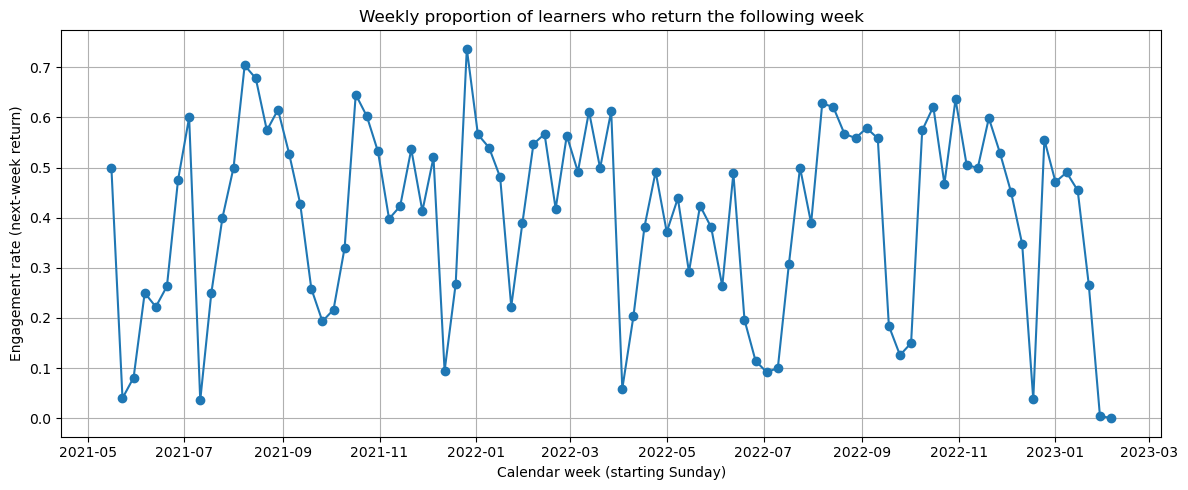

In [10]:
# ---------- Expect `user_week_features` in memory --------------------
try:
    df = user_week_features.copy()
except NameError:
    raise NameError("`user_week_features` is not defined. "
                    "Run the feature‑engineering cell first, then run this plot cell.")


# ---------- ensure the label exists ---------------------------------
if 'engaged_next_week' not in df.columns:
    raise KeyError("The column 'engaged_next_week' is missing. "
                   "Make sure you created the engagement label before plotting.")

# ---------- convert %Y-%U string to a datetime week start (Sunday) ---
df['week_start'] = pd.to_datetime(df['year_week'] + '-0', format='%Y-%U-%w')

# ---------- compute weekly engagement rate --------------------------
weekly_eng = (
    df.groupby('week_start')['engaged_next_week']
      .mean()
      .sort_index()
)

# ---------- plot -----------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(weekly_eng.index, weekly_eng.values, marker='o')
plt.title('Weekly proportion of learners who return the following week')
plt.xlabel('Calendar week (starting Sunday)')
plt.ylabel('Engagement rate (next‑week return)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------------------- CONFIG ----------------------------------
DATASET = user_week_features               # <-- already created
TRAIN_WEEK_CUTOFF = '2022-09'              # use weeks ≤ this for clustering
OUTPUT_DIR = Path('profile_centroids')     # will be created if missing

DIMENSIONS = {
    'Effort'      : ['weekly_events', 'weekly_clicks', 'weekly_time_spent'],
    'Consistency' : ['mean_session_duration', 'std_weekly_activity'],
    'Regularity'  : ['mean_days_between_sessions'],
    'Proactivity' : ['weekly_go_to_theory', 'weekly_early_sessions'],
    'Control'     : ['weekly_next_actions', 'weekly_skip_actions'],
    'Assessment'  : ['weekly_percentage_correct', 'weekly_challenges_completed'],
}

N_CLUSTERS = 3
RANDOM_STATE = 42
# ---------------------------------------------------------------

OUTPUT_DIR.mkdir(exist_ok=True)

# we use Sunday-based year_week strings:  "YYYY-WW"
is_train = DATASET['year_week'] <= TRAIN_WEEK_CUTOFF
train_df = DATASET.loc[is_train].copy()

summary_rows = []

for dim, cols in DIMENSIONS.items():
    # 1) isolate & scale
    X = train_df[cols].astype(float).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    # 2) cluster  (simple K-Means here; swap for Spectral-DTW if needed)
    km = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    centroids = km.cluster_centers_

    # 3) order centroids → Low/Mid/High
    centroid_mean = centroids.mean(axis=1)
    order = centroid_mean.argsort()            # ascending
    ordinal_map = {old: new for new, old in enumerate(order)}
    ordered_labels = pd.Series(labels).map(ordinal_map).values

    # 4) save artefacts
    joblib.dump(scaler,   OUTPUT_DIR / f'{dim}_scaler.pkl')
    np.save   (OUTPUT_DIR / f'{dim}_centroids.npy', centroids)

    # 5) record summary
    summary_rows.append({
        'dimension' : dim,
        'centroid_means' : centroid_mean.tolist(),
        'order_low_to_high' : order.tolist()
    })

    print(f'✓ {dim:11s}  Silhouette={silhouette_score(X_scaled, labels):.3f}')

# write a human-readable summary
with open(OUTPUT_DIR / 'centroid_summary.json', 'w') as f:
    json.dump(summary_rows, f, indent=2)

print(f'\nAll artefacts saved in “{OUTPUT_DIR.resolve()}”.')

✓ Effort       Silhouette=0.543
✓ Consistency  Silhouette=0.645
✓ Regularity   Silhouette=0.844
✓ Proactivity  Silhouette=0.835
✓ Control      Silhouette=0.723
✓ Assessment   Silhouette=0.606

All artefacts saved in “/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/m4/features/profile_centroids”.


In [12]:

user_week_features = user_week_features.drop(columns=['week_period','week_start'])

# ======================================================================
# DATASET ASSEMBLY  +  MODEL BENCHMARK (profiles vs. no-profiles)
# ======================================================================
import pandas as pd, numpy as np, joblib
from pathlib import Path
from sklearn.metrics import pairwise_distances_argmin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier           # pip install lightgbm
from catboost import CatBoostClassifier       # pip install catboost

# --------------------- 0 · CONFIG ---------------------------------
DIMENSIONS = ['Effort','Consistency','Regularity','Proactivity','Control','Assessment']
CENT_DIR   = Path('profile_centroids')
LAG_WEEKS  = 1
DROP_IDS   = ['user_id','year_week']          # add 'class_id', etc. if present

DIM_COLUMNS = {                   # MUST match offline clustering
    'Effort'      : ['weekly_events', 'weekly_clicks', 'weekly_time_spent'],
    'Consistency' : ['mean_session_duration', 'std_weekly_activity'],
    'Regularity'  : ['mean_days_between_sessions'],
    'Proactivity' : ['weekly_go_to_theory', 'weekly_early_sessions'],
    'Control'     : ['weekly_next_actions', 'weekly_skip_actions'],
    'Assessment'  : ['weekly_percentage_correct', 'weekly_challenges_completed'],
}

# --------------------- 1 · copy frame & build ordinal labels -------
df = user_week_features.copy()

for dim, cols in DIM_COLUMNS.items():
    scaler    = joblib.load(CENT_DIR/f'{dim}_scaler.pkl')
    cents     = np.load   (CENT_DIR/f'{dim}_centroids.npy')
    order     = cents.mean(axis=1).argsort()
    Xscaled   = scaler.transform(df[cols])
    raw_lbl   = pairwise_distances_argmin(Xscaled, cents)
    df[f'{dim}_ord'] = pd.Series(raw_lbl).map({o:i for i,o in enumerate(order)}).astype('int8')

profile_cols = [f'{d}_ord' for d in DIMENSIONS]

# --------------------- 2 · optional lag-1 / delta numeric ----------
numeric_base = df.select_dtypes(include='number').columns\
                 .difference(['engaged_next_week'] + profile_cols + DROP_IDS)

df = df.sort_values(['user_id','year_week'])
for col in numeric_base:
    df[f'{col}_lag1']  = df.groupby('user_id')[col].shift(LAG_WEEKS)
    df[f'{col}_delta'] = df[col] - df[f'{col}_lag1']
df = df.dropna()               # drop first week of each user

# --------------------- 3 · build X / y  ----------------------------
y = df['engaged_next_week'].astype('int8')
X = df.drop(columns=['engaged_next_week'] + DROP_IDS)

# keep fresh lists after lag expansion
numeric_cols = X.select_dtypes(include='number').columns\
                .difference(profile_cols).tolist()

# preprocessing 1: with profiles
pre_with = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), profile_cols)
])

# preprocessing 2: no profiles
pre_no   = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols)
])

# --------------------- 4 · model zoo -------------------------------
MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=600, class_weight='balanced',
                                            n_jobs=-1, random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42),
    'LightGBM'     : LGBMClassifier(n_estimators=600, learning_rate=0.05,
                                    objective='binary', class_weight='balanced',
                                    random_state=42),
    'CatBoost'     : CatBoostClassifier(depth=6, learning_rate=0.08, iterations=400,
                                        loss_function='Logloss', verbose=False,
                                        random_seed=42)
}

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append( f1_score(y.iloc[te], yhat) )
    return np.mean(aucs), np.mean(f1s)

tscv = TimeSeriesSplit(n_splits=5)
rows = []

for name, clf in MODELS.items():
    # --- with profiles
    pipe1 = clf if name=='CatBoost' else make_pipeline(pre_with, clf)
    auc1, f11 = cross_val(pipe1, X, y, tscv)
    rows.append({'model':name, 'variant':'with_profile', 'AUC':auc1, 'F1':f11})

    # --- no profiles
    X_no = X.drop(columns=profile_cols)
    pipe2 = clf if name=='CatBoost' else make_pipeline(pre_no, clf)
    auc2, f12 = cross_val(pipe2, X_no, y, tscv)
    rows.append({'model':name, 'variant':'no_profile', 'AUC':auc2, 'F1':f12})

leader = pd.DataFrame(rows).sort_values(['AUC'], ascending=False).reset_index(drop=True)
display(leader.style.background_gradient(cmap='viridis', subset=['AUC','F1']))

best = leader.iloc[0]
print(f"\nBest: {best['model']} ({best['variant']})  AUC={best['AUC']:.3f}")

# --------------------- 5 · fit on FULL data & save -----------------
best_clf = MODELS[best['model']]
pre_best = pre_with if best['variant']=='with_profile' else pre_no
final_pipe = best_clf if best['model']=='CatBoost' else make_pipeline(pre_best, best_clf)
final_pipe.fit(X if best['variant']=='with_profile' else X_no, y)
joblib.dump(final_pipe, 'learnnavi_best_model.pkl')
print("Saved → learnnavi_best_model.pkl")



/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1199, number of negative: 1593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5720
[LightGBM] [Info] Number of data points in the train set: 2792, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2194, number of negative: 3390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6018
[LightGBM] [Info] Number of data points in the train set: 5584, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3580, number of negative: 4796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6222
[LightGBM] [Info] Number of data points in the train set: 8376, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4617, number of negative: 6551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6331
[LightGBM] [Info] Number of data points in the train set: 11168, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5602, number of negative: 8358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 13960, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1199, number of negative: 1593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5696
[LightGBM] [Info] Number of data points in the train set: 2792, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2194, number of negative: 3390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5994
[LightGBM] [Info] Number of data points in the train set: 5584, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3580, number of negative: 4796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6198
[LightGBM] [Info] Number of data points in the train set: 8376, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4617, number of negative: 6551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6307
[LightGBM] [Info] Number of data points in the train set: 11168, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5602, number of negative: 8358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6379
[LightGBM] [Info] Number of data points in the train set: 13960, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,model,variant,AUC,F1
0,GradientBoost,no_profile,0.751997,0.550636
1,GradientBoost,with_profile,0.751532,0.545153
2,RandomForest,no_profile,0.749780,0.556793
3,RandomForest,with_profile,0.748824,0.555807
4,CatBoost,no_profile,0.747282,0.564616
5,CatBoost,with_profile,0.747245,0.562701
6,LightGBM,with_profile,0.738677,0.578551
7,LightGBM,no_profile,0.737808,0.578585
8,Logistic,no_profile,0.579346,0.471394
9,Logistic,with_profile,0.572765,0.466119



Best: GradientBoost (no_profile)  AUC=0.752
Saved → learnnavi_best_model.pkl


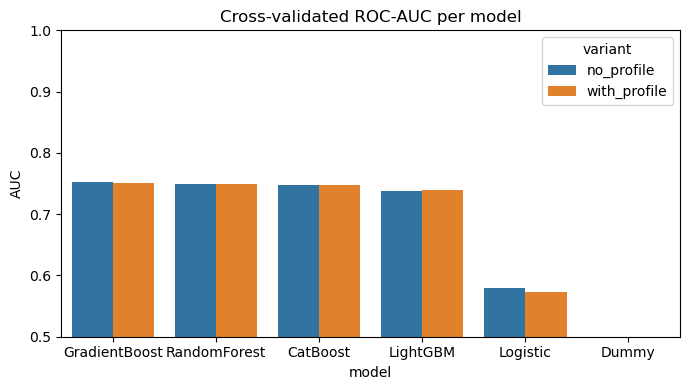

In [13]:
import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.barplot(data=leader, x='model', y='AUC', hue='variant')
plt.title('Cross-validated ROC-AUC per model')
plt.ylim(0.5, 1)
plt.tight_layout(); plt.show()

In [14]:
best_pipe = joblib.load('learnnavi_best_model.pkl')

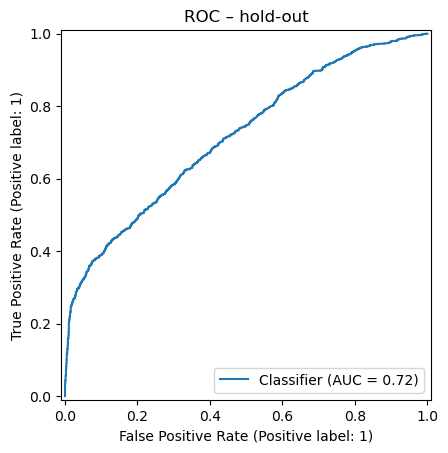

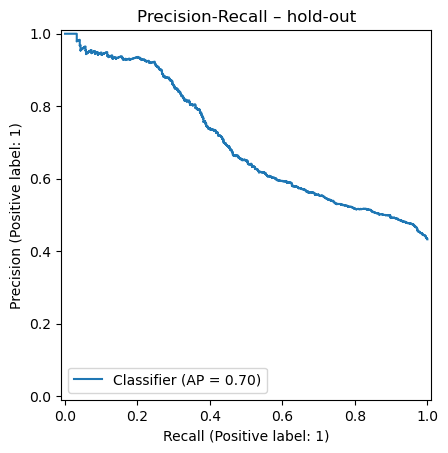

In [15]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
best_pipe.fit(X_train, y_train)
prob = best_pipe.predict_proba(X_hold)[:,1]

RocCurveDisplay.from_predictions(y_hold, prob)
plt.title('ROC – hold-out'); plt.show()

PrecisionRecallDisplay.from_predictions(y_hold, prob)
plt.title('Precision-Recall – hold-out'); plt.show()

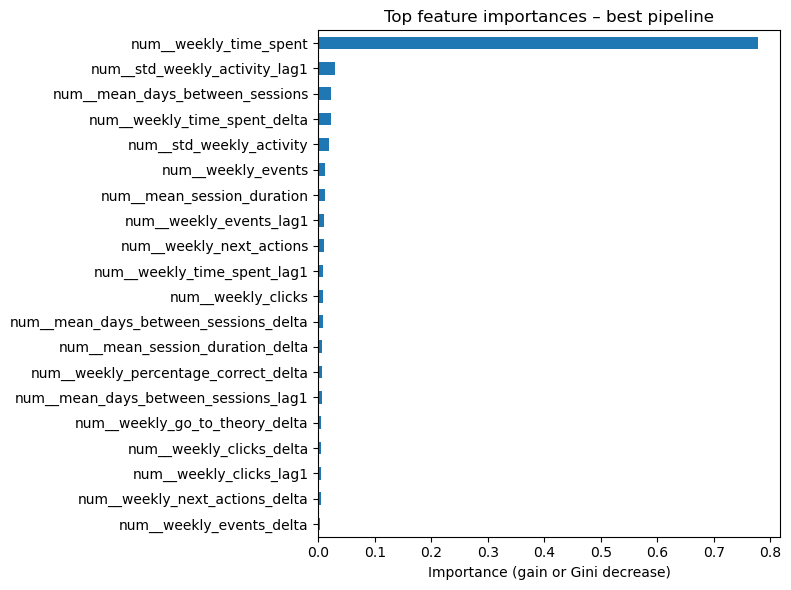

In [16]:
import joblib, pandas as pd, matplotlib.pyplot as plt

# ------------ CONFIG -------------------------------------------------
MODEL_PATH = 'learnnavi_best_model.pkl'   # adjust if you saved under another name
TOPN       = 20                           # top features to display
# --------------------------------------------------------------------

# Load model
best_pipe = joblib.load(MODEL_PATH)

# Extract feature names after preprocessing
if hasattr(best_pipe, 'named_steps'):
    # sklearn Pipeline path
    preproc = best_pipe.named_steps.get('columntransformer', None) or \
              best_pipe.named_steps.get('columntransformer0', None) or \
              [s for s in best_pipe.named_steps.values() if isinstance(s, type(best_pipe)).__name__=='ColumnTransformer'][0]
    model   = [s for s in best_pipe.named_steps.values() if s is not preproc][-1]
    feat_names = preproc.get_feature_names_out()
else:
    # CatBoost path (model alone)
    model = best_pipe
    feat_names = [f'feat_{i}' for i in range(model.feature_count_)]

# Handle RandomForest / GBDT / LightGBM feature importance attribute
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
elif hasattr(model, 'coef_'):
    importances = model.coef_.flatten()
else:
    raise ValueError("Model type not supported for visualisation in this snippet.")

# Build DataFrame and sort
fi = (pd.Series(importances, index=feat_names)
        .sort_values(ascending=False)
        .head(TOPN))

# Plot
plt.figure(figsize=(8,6))
fi.sort_values().plot(kind='barh')
plt.title('Top feature importances – best pipeline')
plt.xlabel('Importance (gain or Gini decrease)')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Save active_ids to a .npy file
np.save("active_ids.npy", active_ids)

# To load it later
active_ids = np.load("active_ids.npy")
print(loaded_active_ids)

[387604 387605 387608 ... 421945 426394 427577]


## RQ2: What are the effects of Lernnavi’s automated text-evaluation methods on bias in student performance assessments, both across subject topics and among different demographic groups?

## Preprocessing Pipeline

1. **Data Ingestion & Merging**  
   - We loaded four CSVs:  
     - **transactions.csv** (student answers, system labels, timestamps)  
     - **documents.csv** (question text, canonical solutions)  
     - **users.csv.gz** (demographics: user ID, gender, canton, class level)  
     - **topics_translated.csv** (human-readable German topic names)  
   - Renamed keys where needed (e.g. align `document_id` and `version` columns) and performed a series of `.merge()` operations on the DataFrames so that each row now contains:  
     1. a student answer and its system‐assigned label  
     2. the canonical solution text  
     3. the user’s demographic info (gender, canton, etc.)  
     4. the topic metadata (German topic name, translated fields, and the `math` flag).  

2. **Active‐User & Task‐Type Filtering**  
   - We filtered to only the “active” users provided in our `active_ids` list, ensuring we analyze the current, relevant student population.  
   - We parsed each “student_answer” and “canonical_sol” field as JSON and kept only those entries where the `"type"` key equals `"OPEN_TASK"`. In other words, we discarded all multiple‐choice interactions and retained purely open‐ended questions.  
   - We further dropped any rows with missing or empty (`"nan"`) text in either the student answer or solution.

3. **Topic & Math‐Flag Filtering**  
   - After extracting the open‐task text from each JSON (`.get("openInput")` for answers and `.get("solutionText")` for solutions), we filtered out any leftover blank strings.  
   - We then restricted our analysis to non‐math questions (`df["math"] == 0.0`), focusing on purely language‐based tasks (grammar, vocabulary, reading comprehension, etc.).

4. **Text Cleaning**  
   - We applied a `clean_text()` function to strip any HTML tags, collapse repeated whitespace, and trim leading/trailing spaces. This normalization step reduces noise before computing embeddings.

5. **Embedding Generation on MPS**  
   - We detected Apple’s MPS backend with `torch.backends.mps.is_available()`, and fell back to CPU if MPS was unavailable. Running on MPS dramatically speeds up inference on Mac‐Silicon GPUs.  
   - We loaded a multilingual SBERT model (`distiluse-base-multilingual-cased-v2`) directly onto the chosen device. This pretrained sentence‐Transformer is well‐suited for German language tasks and yields strong semantic embeddings.  
   - In two batched calls (`batch_size=128`), we encoded each student answer (`emb_answers`) and each canonical solution (`emb_solutions`) into 768‐dim vectors.  
   - These embeddings were saved to disk as `.npy` files so that future experiments don’t need to recompute them.

**Why These Choices?**  
- **Merging multiple tables:** ensures each record links student responses, gold‐standard solutions, and relevant metadata (topic, demographics).  
- **Active‐user & open‐task filtering:** removes inactive or non‐textual interactions, focusing our analysis on genuinely open‐ended, current student work.  
- **Math‐flag exclusion:** avoids numeric‐focused tasks that SBERT may struggle with, letting us concentrate on linguistic evaluation.  
- **SBERT embeddings on MPS:** provides a fast, consistent semantic baseline (our “oracle”) for comparing each answer against its solution.  
- **Saving `.npy` files:** avoids wasting GPU/CPU time on repeated encoding, speeding up downstream analyses (clustering, error‐flagging, bias checks, etc.).

With this preprocessing completed, the DataFrame `df` now contains:
- Cleaned open‐text fields  
- Demographics & topic labels  
- Precomputed SBERT embeddings for every answer‐solution pair.  
This unified, cleaned dataset powers the subsequent error‐rate computation, clustering analyses, and bias audits.  


In [17]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#import ace_tools as tools
import re

In [18]:
# 1. Ingest & Join
import pandas as pd

# 1.1 Load your CSVs (adjust paths if needed)
tx     = pd.read_csv("/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/data/Lernnavi/transactions.csv")
docs   = pd.read_csv("/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/data/Lernnavi/documents.csv")
users  = pd.read_csv("/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/data/Lernnavi/users.csv.gz")
topics = pd.read_csv("/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/data/Lernnavi/topics_translated.csv")

# 1.2 Rename to align keys
tx   = tx.rename(columns={"document_id":"document_id", "document_version":"version"})
docs = docs.rename(columns={"document_id":"document_id", "version":"version"})

# 1.3 Merge into one DataFrame
df = tx.merge(docs,   on=["document_id","version"], how="left")
df  =  df.merge(users,  on="user_id",                 how="left")

df = df.merge(topics, left_on="topic_id_y", right_on="id", how="left")

In [19]:
df = df[df["user_id"].isin(active_ids)].copy()

In [20]:
# 2. Clean & Rename Text Columns
import re
def clean_text(s):
    s = re.sub(r"<[^>]+>", " ", str(s))      # strip any HTML
    return re.sub(r"\s+", " ", s).strip()    # normalize whitespace

df["student_answer"] = df["input"].map(clean_text)
df["canonical_sol"]  = df["solution"].map(clean_text)
df["sys_label"]      = df["evaluation"]    # values: 'correct','partial','incorrect'

In [21]:
df = df[df['student_answer']!='nan']
df = df[df['canonical_sol']!='nan']

In [22]:
df["answer_dict"] = df["student_answer"].apply(json.loads)
df["sol_dict"] = df["canonical_sol"].apply(json.loads)

In [23]:
df[df['type_y']=="OPEN"].sol_dict.iloc[89]

{'type': 'OPEN_TASK',
 'solutionText': ', Das Angebot besticht durch eine Sicht aufs Meer, die ungewöhnlich ist.'}

In [24]:
df_open = df[df["answer_dict"].apply(lambda d: d.get("type") == "OPEN_TASK")].copy()

In [25]:
df_open.columns


Index(['transaction_id', 'transaction_token', 'user_id', 'document_id',
       'version', 'evaluation', 'input', 'start_time', 'commit_time',
       'user_agent', 'solution', 'type_x', 'session_id', 'topic_id_x',
       'session_closed', 'session_type', 'session_accepted', 'challenge',
       'challenge_id', 'challenge_order', 'challenge_name', 'title', 'type_y',
       'created_time', 'author_id', 'content', 'status', 'version_comment',
       'topic_id_y', 'gender', 'canton', 'class_level', 'study', 'class_id',
       'id', 'german_name', 'german_description', 'name', 'description',
       'math', 'student_answer', 'canonical_sol', 'sys_label', 'answer_dict',
       'sol_dict'],
      dtype='object')

In [26]:
df_open["student_answer"] = df_open["answer_dict"].apply(lambda d: d.get("openInput", ""))

In [27]:
df_open["canonical_sol"] = df_open["sol_dict"].apply(lambda d: d.get("solutionText", ""))

In [28]:
df_open = df_open[df_open['canonical_sol']!=""]

In [29]:
df = df_open.copy()

In [30]:
df = df[df.math == 0.0]

In [31]:
import torch


# 1. Select MPS (Apple Silicon GPU) if available, else CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# 2. Load the SBERT model directly onto MPS
model = SentenceTransformer("distiluse-base-multilingual-cased-v2", device=str(device))

# 3. Prepare lists of texts
answers   = df["student_answer"].tolist()
solutions = df["canonical_sol"].tolist()

# 4. Encode in batches on MPS
emb_answers = model.encode(
    answers,
    batch_size=128,
    convert_to_numpy=True,
    show_progress_bar=True
)
emb_solutions = model.encode(
    solutions,
    batch_size=128,
    convert_to_numpy=True,
    show_progress_bar=True
)

# 5. Store back to DataFrame
df["emb_answer"]   = list(emb_answers)
df["emb_solution"] = list(emb_solutions)

print("Embeddings computed on:", device)


Using device: mps


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Embeddings computed on: mps


In [32]:
np.save(f"emb_answers.npy", emb_answers)
np.save(f"emb_solutions.npy", emb_solutions)

In [33]:
emb_answers = np.load(f"emb_answers.npy")
emb_solutions = np.load(f"emb_solutions.npy")

## Feature Engineering and Clustering Pipeline

1. **Embedding Computation**  
   - **Model Selection**: We used the `distiluse-base-multilingual-cased-v2` SentenceTransformer checkpoint because it offers a compact yet effective multilingual embedding space.  
   - **Answer & Solution Encoding**: Each student’s answer and its corresponding canonical solution were passed through the SBERT model (on MPS/CPU), producing two 512‐dimensional vectors (`emb_answer` and `emb_solution`). These dense embeddings capture semantic meaning in a continuous vector space.

2. **Cosine‐Similarity Oracle**  
   - **Cosine Similarity Score**: For each answer–solution pair, we computed  
     \[
       \text{cosine\_sim} = \frac{\langle \mathbf{emb\_answer},\, \mathbf{emb\_solution}\rangle}{\|\mathbf{emb\_answer}\|\;\|\mathbf{emb\_solution}\|}.
     \]  
   - **Predicted Label Assignment**: We converted the raw cosine score into a discrete “oracle” grade:  
     - \(\ge 0.80\) → “CORRECT”  
     - \(\ge 0.50\) → “PARTIAL”  
     - \(< 0.50\) → “WRONG”  
   - **Error Flagging**: We compared the SBERT‐based label (the “oracle”) to Lernnavi’s system label (`sys_label`). Whenever they differed, we marked `error_flag = 1`, otherwise `error_flag = 0`. This binary flag highlights all answer–solution pairs where our semantic oracle disagrees with the built‐in grader.

3. **Delta Vector Calculation**  
   - **Vector Difference**: For each row, we computed  
     \[
       \Delta = \mathbf{emb\_answer} - \mathbf{emb\_solution}.
     \]  
     This 512‐dimensional “delta” vector encodes the direction and magnitude of semantic movement from the canonical solution toward the student’s actual answer.

4. **Constructing the Clustering Feature Matrix**  
   - **Feature Concatenation**: We built a combined feature vector for each answer–solution pair by horizontally stacking:  
     1. The 512‐dimensional delta vector (semantic gap)  
     2. A scalar cosine similarity score (1‐dimensional)  
     3. The binary error flag (1‐dimensional)  
   - **Resulting Dimensionality**: Each row’s feature vector has dimension \(512 + 1 + 1 = 514.\)

5. **Dimensionality Reduction (for Visualization Only)**  
   - **PCA on Feature Matrix**: We applied PCA (2 components) to the 514‐dimensional data strictly for plotting purposes, yielding two new columns `pca1` and `pca2`. These two principal components do not feed into the clustering algorithm; they serve only to visualize cluster separation in 2D.

6. **Elbow Method & K-Means Clustering**  
   - **Finding the Optimal k**: We ran K-Means on the 514‐dimensional feature matrix for \(k = 1\) through \(k = 15\), recording each model’s inertia. The plot of inertia vs. \(k\) (the “elbow curve”) showed a clear bend around \(k = 4\).  
   - **Final Clustering**: Based on the elbow heuristic, we fit K-Means with \(k = 4\) clusters. Each answer–solution pair was then assigned one of four cluster labels (`cluster = 0, 1, 2, or 3`).

7. **Why This Feature Design?**  
   - **Delta Vector (512 dims)**: Encodes *precisely which semantic directions* differ between the student’s answer and the canonical solution. Large delta values indicate major conceptual gaps or introduced errors; small deltas indicate near‐perfect alignment.  
   - **Cosine Similarity (1 dim)**: Provides a single, interpretable scalar—“how close are these two texts overall?”—which summarizes the delta into a normalized score.  
   - **Error Flag (1 dim)**: Captures volumetrically whether our SBERT oracle *agrees or disagrees* with the built‐in system. Rows with `error_flag=1` are precisely the instances we want to investigate for bias or inconsistency.  
   - By combining these three components, each row’s feature vector conveys both *continuous semantic distance* (delta + similarity) and *discrete grader alignment* (error flag). Clustering on this 514‐dimensional space groups answers by their pattern of semantic gap + grader agreement. For example, one cluster might correspond to “small semantic gap, system says WRONG but SBERT says CORRECT,” whereas another cluster might be “large semantic gap, system says CORRECT but SBERT says WRONG.”  

This feature engineering strategy allows us to uncover subpopulations of answer‐solution pairs that share similar grading patterns and semantic relationships. Once clustered, we can analyze each cluster’s topic distribution, question types, or demographic skew to identify systematic biases in Lernnavi’s automatic evaluation pipeline.  


In [34]:
def cos_sim(u,v): return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))
sims          = np.array([cos_sim(a,s) for a,s in zip(emb_answers,emb_solutions)])
df["cosine_sim"] = sims

def pred_label(sim):
    if sim>=0.8: return "CORRECT"
    if sim>=0.5: return "PARTIAL"
    return "WRONG"

df["pred_label"] = df["cosine_sim"].map(pred_label)
df["error_flag"] = df["pred_label"] != df["sys_label"]

In [35]:
delta    = emb_answers - emb_solutions
features = np.hstack([delta, sims.reshape(-1,1), df["error_flag"].astype(int).values.reshape(-1,1)])

In [36]:
pca      = PCA(n_components=2, random_state=42)
coords   = pca.fit_transform(features)
df["pca1"], df["pca2"] = coords[:,0], coords[:,1]

kmeans   = KMeans(n_clusters=4, random_state=42).fit(features)
df["cluster"] = kmeans.labels_

Elbow Method Data:
 k     inertia
 1 2108.196091
 2 1189.685396
 3  959.510709
 4  810.463971
 5  783.730242
 6  734.192506
 7  692.518187
 8  672.048426
 9  650.226021
10  623.503913
11  608.396591
12  604.908538
13  591.316448
14  593.615306
15  575.724494


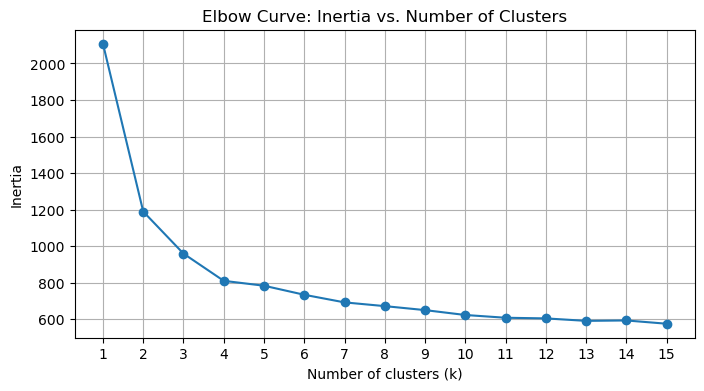

In [37]:
Ks = list(range(1, 16))
inertia = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42).fit(features)
    inertia.append(km.inertia_)

# 3. Display inertia values
df_elbow = pd.DataFrame({"k": Ks, "inertia": inertia})
print("Elbow Method Data:")
print(df_elbow.to_string(index=False))

# 4. Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(Ks, inertia, marker='o')
plt.title("Elbow Curve: Inertia vs. Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(Ks)
plt.grid(True)
plt.show()

## Results

In [38]:
cluster_summary = df.groupby("cluster").agg(
    count     = ("transaction_id","count"),
    err_rate  = ("error_flag","mean")
).reset_index()
print(cluster_summary)

print("\nGender skew:")
print(df.groupby(["cluster","gender"]).size().unstack(fill_value=0))



   cluster  count  err_rate
0        0    541       1.0
1        1   1587       0.0
2        2    217       0.0
3        3   1235       1.0

Gender skew:
gender   FEMALE  MALE  STAR
cluster                    
0           298   190    23
1           867   583    54
2           125    82     5
3           740   435    23


In [39]:
import plotly.express as px

# 1. Merge cluster_summary into your df so hover can show count & err_rate
cluster_summary = df.groupby("cluster").agg(
    count    = ("transaction_id","count"),
    err_rate = ("error_flag",   "mean")
).reset_index()
df_plot = df.merge(cluster_summary, on="cluster", how="left")

# 2. Interactive scatter
fig = px.scatter(
    df_plot,
    x="pca1", y="pca2",
    color="cluster",
    symbol="cluster",              # or symbol="gender" to also split by gender
    labels={"pca1":"PCA 1","pca2":"PCA 2"},
    title="Clusters of Answer–Solution Differences",
    hover_data={
        "cluster": True,
        "count":    True,
        "err_rate": ':.2f',
        "sys_label":True,
        "gender":   True
    },
    width=800, height=600
)

# 3. Style tweaks
fig.update_traces(marker=dict(size=6, opacity=0.7, line=dict(width=0)))
fig.update_layout(
    legend_title_text="Cluster",
    font=dict(size=12),
    title_font=dict(size=16),
    margin=dict(l=40, r=40, t=80, b=40),
)

fig.show()

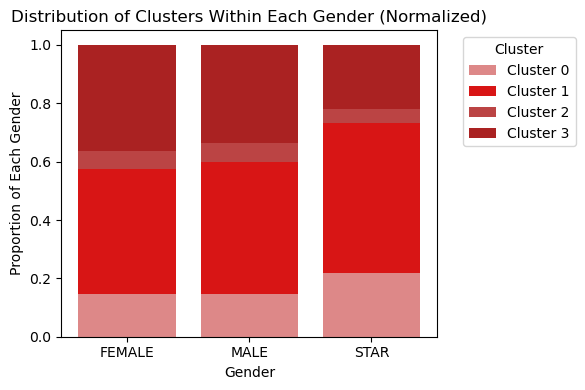

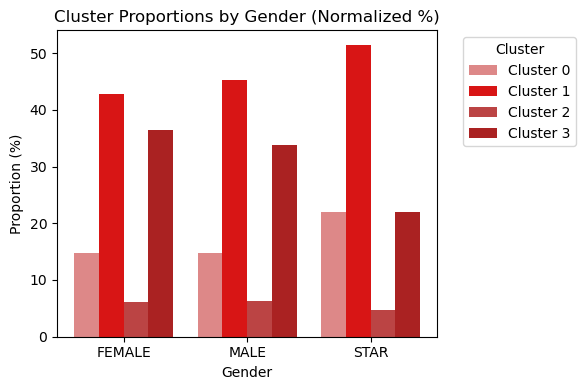

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute raw counts: clusters × genders
gender_counts = (
    df.groupby(['cluster','gender'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# 2. Normalize per gender: divide each cluster’s count by that gender’s total
gender_pct_by_gender = gender_counts.div(gender_counts.sum(axis=0), axis=1)

# 3. Define a 4-color palette for the clusters
cluster_colors = ['#DD8888', '#D81515FF', '#BB4444', '#AA2222']  # one color per cluster

# 4. 100% stacked bar chart (bars = genders, segments = clusters)
genders   = gender_pct_by_gender.columns.tolist()
clusters  = gender_pct_by_gender.index.astype(str).tolist()
bottom    = np.zeros(len(genders))

fig, ax = plt.subplots(figsize=(6,4))
for color, cluster in zip(cluster_colors, clusters):
    vals = gender_pct_by_gender.loc[int(cluster)].values
    ax.bar(
        genders,
        vals,
        bottom=bottom,
        label=f"Cluster {cluster}",
        color=color
    )
    bottom += vals

ax.set_ylabel("Proportion of Each Gender")
ax.set_xlabel("Gender")
ax.set_title("Distribution of Clusters Within Each Gender (Normalized)")
ax.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Grouped bar chart of proportions per gender
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(genders))
width = 0.2  # spacing for 4 clusters

for i, cluster in enumerate(clusters):
    props = gender_pct_by_gender.loc[int(cluster)].values * 100  # convert to %
    ax.bar(
        x + (i-1.5)*width,  # centers at -(1.5, 0.5, 2.5, 3.5)*width
        props,
        width,
        label=f"Cluster {cluster}",
        color=cluster_colors[i]
    )

ax.set_xticks(x)
ax.set_xticklabels(genders)
ax.set_ylabel("Proportion (%)")
ax.set_xlabel("Gender")
ax.set_title("Cluster Proportions by Gender (Normalized %)")
ax.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.savefig("student_engagement_poster.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()



In [59]:
for c,name in zip([0,1,2,3],["False Negatives: Low-Sim Mismatches","True Positives: High-Sim Agreement","True Negatives: Low-Sim Agreement","False Positives: High-Sim Mismatches"]):
    print(f"\n== Cluster {name} examples ==")
    display(df[df.cluster==c][["student_answer","canonical_sol","sys_label","cosine_sim","gender", "challenge","name"]].head(20))


== Cluster False Negatives: Low-Sim Mismatches examples ==


,student_answer,canonical_sol,sys_label,cosine_sim,gender,challenge,name
19434,"Nachdem eine Umstrukturierung erfolgt war,",", Weil umstrukturiert wird/wurde, werden viele...",CORRECT,0.452955,NaN,False,Relationship between clauses/attributes and su...
29046,"Bestätigung, Erstaunen, Seufzer",", Emotionen, Bewegtheit, Interaktion",CORRECT,0.262230,NaN,False,Interjections
29111,"Bestätigung, Erstaunen, Seufzen, Verstärkung",", Emotionen, Bewegtheit, Interaktion",CORRECT,0.339618,NaN,False,Interjections
48840,Natasche er,", Eine Kollegin meint, Natascha sei an einer G...",PARTIAL,0.050011,MALE,False,Mode
54723,Fussnote ist der Duft der aus dem Fuss ausdrin...,", Der ""Fuss"" als Standfläche des Menschen wird...",CORRECT,0.142188,FEMALE,False,Transferred meaning
54725,fusst heisst so viel wie stammt,", ""Es fusst auf..."" bedeutet so viel wie ""Es b...",CORRECT,0.169949,FEMALE,False,Transferred meaning
59312,nicht gut ankommt bei den Lehrern,", ""Schlecht angeschrieben sein"" stammt vom Aus...",CORRECT,0.097605,FEMALE,False,Transferred meaning
59344,Untere Notize,", Der ""Fuss"" als Standfläche des Menschen wird...",CORRECT,0.128609,MALE,False,Transferred meaning
59399,er hat sich zeitgelassen,", In Verbindung mit ""Zeit"" meint ""vertrödeln"" ...",CORRECT,0.224463,MALE,False,Transferred meaning
59513,"Die unterste Note, Die Grundnote auf der alles...",", Der ""Fuss"" als Standfläche des Menschen wird...",CORRECT,0.143057,MALE,False,Transferred meaning



== Cluster True Positives: High-Sim Agreement examples ==


,student_answer,canonical_sol,sys_label,cosine_sim,gender,challenge,name
15141,Die Parlamentarier beschlossen nach einer lang...,", Die Parlamentarier hatten nach einer langen ...",CORRECT,0.904071,NaN,False,Genus verbi/Active passive
19433,Das Museum kann nicht alle zur Anschaffung emp...,", Das Museum kann nicht alle zur Anschaffung e...",CORRECT,0.994509,NaN,False,Relationship between clauses/attributes and su...
19549,Das neue Reglement tritt nach begonnener Ausbi...,", Das neue Reglement tritt bei Ausbildungsbegi...",CORRECT,0.985695,NaN,False,Relationship between clauses/attributes and su...
20099,Das neue Reglement tritt nach Ausbildungsbegin...,", Das neue Reglement tritt bei Ausbildungsbegi...",CORRECT,0.993432,NaN,False,Relationship between clauses/attributes and su...
20100,Wegen mangelhafter Französischkenntnisse reist...,", Wegen mangelhafter Französischkenntnisse rei...",CORRECT,0.996026,NaN,False,Relationship between clauses/attributes and su...
20101,"Die Ferienhäuser, die überteuert waren, bliebe...",", Die Ferienhäuser, die überteuert sind/waren,...",CORRECT,0.953903,NaN,False,Relationship between clauses/attributes and su...
20102,"Aktienkäufe, die gestern getätigt worden sind,...",", Die Aktienkäufe, die gestern getätigt wurden...",CORRECT,0.988844,NaN,False,Relationship between clauses/attributes and su...
20103,"Das Angebot besticht, weil die Sicht aufs Meer...",", Das Angebot besticht durch eine Sicht aufs M...",CORRECT,0.942284,NaN,False,Relationship between clauses/attributes and su...
37922,"Einer der Polizisten gab zu bedenken, es verst...",", Einer der Polizisten gab zu bedenken, es sei...",CORRECT,0.992539,FEMALE,True,Mode
38912,"Einer der Polizisten gab zu bedenken, er verst...",", Einer der Polizisten gab zu bedenken, es sei...",CORRECT,0.981974,FEMALE,True,Mode



== Cluster True Negatives: Low-Sim Agreement examples ==


,student_answer,canonical_sol,sys_label,cosine_sim,gender,challenge,name
59415,nicht in guter Erinnerung sein,", ""Schlecht angeschrieben sein"" stammt vom Aus...",WRONG,0.049779,FEMALE,False,Transferred meaning
97450,gbjsrcheqjmuw fw,", Auch wenn die Politikerinnen und Politiker u...",WRONG,-0.015290,FEMALE,False,Genus verbi/Active passive
106091,adverbiale der Zeit\n,", Satzpartikel/Adverbiale",WRONG,0.402776,FEMALE,True,Determination of the elements of the sentence
122325,E,", Die Bevölkerung wird nach der Feier von der ...",WRONG,-0.003219,MALE,False,Genus verbi/Active passive
147663,Zeit durch trödeln versäumen.,", In Verbindung mit ""Zeit"" meint ""vertrödeln"" ...",WRONG,0.384174,FEMALE,False,Transferred meaning
147702,es ist unten\n,", Der ""Fuss"" als Standfläche des Menschen wird...",WRONG,0.322459,FEMALE,False,Transferred meaning
244165,nicht sinnvoll nutzte,", In Verbindung mit ""Zeit"" meint ""vertrödeln"" ...",WRONG,0.173929,NaN,False,Transferred meaning
246491,k,", Die Bevölkerung wird nach der Feier von der ...",WRONG,0.002812,STAR,False,Genus verbi/Active passive
270564,Das Gesetzt wur\n,", Die Parlamentarier hatten nach einer langen ...",WRONG,0.251049,MALE,False,Genus verbi/Active passive
271511,f,", Die Parlamentarier hatten nach einer langen ...",WRONG,-0.031100,FEMALE,False,Genus verbi/Active passive



== Cluster False Positives: High-Sim Mismatches examples ==


,student_answer,canonical_sol,sys_label,cosine_sim,gender,challenge,name
37923,"Einer der Polizisten gab zu bedenken, es verst...",", Einer der Polizisten gab zu bedenken, es sei...",WRONG,0.994607,FEMALE,True,Mode
38725,"Eine Kollegin meinte, Natascha erkrank an eine...",", Eine Kollegin meint, Natascha sei an einer G...",WRONG,0.989637,MALE,False,Mode
39533,"Einer der Polizisten gab zu bedenken, es verst...",", Einer der Polizisten gab zu bedenken, es sei...",WRONG,0.994607,FEMALE,True,Mode
39559,"Einer der Polizisten gab zu bedenken, es verst...",", Einer der Polizisten gab zu bedenken, es sei...",WRONG,0.980997,FEMALE,True,Mode
39676,"Eine der Polizisten bedenke, es verstriche noc...",", Einer der Polizisten gab zu bedenken, es sei...",WRONG,0.975457,FEMALE,True,Mode
39962,"Natascha erkrankte an einer Grippe, wohingegen...",", Eine Kollegin meint, Natascha sei an einer G...",WRONG,0.947767,FEMALE,False,Mode
40062,"Eine Kollegin meint, Natascha wäre an einer Gr...",", Eine Kollegin meint, Natascha sei an einer G...",WRONG,0.966814,FEMALE,False,Mode
40351,"Einer der Polizisten gäbe zu bedenken, es vers...",", Einer der Polizisten gab zu bedenken, es sei...",WRONG,0.980914,MALE,True,Mode
54092,"Eine Kollegin meinte, Natascha wäre erkrankt a...",", Eine Kollegin meint, Natascha sei an einer G...",WRONG,0.977284,MALE,False,Mode
55181,"Eine Kollegin meint, Natascha erkranke an eine...",", Eine Kollegin meint, Natascha sei an einer G...",WRONG,0.994412,FEMALE,False,Mode


## Interpretation of Clustering Results

**1. Cluster Sizes & Error Rates**
- **Clusters 0 & 3**: 100% error rate (system label ≠ SBERT‐cosine “oracle”), indicating complete disagreement on every example.
- **Clusters 1 & 2**: 0% error rate (system label = SBERT‐cosine), indicating full agreement.

**2. Gender Composition**
- All clusters have a similar female:male ratio (~55–60% female, ~35–40% male).
- No cluster shows a strong gender skew, suggesting no obvious gender bias in the agreement/disagreement patterns.

**3. PCA Visualization**
- The “agreement” clusters (1 & 2) form one side of the PCA plot, where SBERT‐cosine and the system both concur.
- The “disagreement” clusters (0 & 3) form a separate, well‐segmented group in PCA space, reflecting fundamentally different answer–solution similarity patterns.

**4. Key Takeaways**
- **Clusters 1 & 2** capture cases where both SBERT and Lernnavi’s grader agree (straightforward, semantically clear answers).
- **Clusters 0 & 3** highlight systematic conflicts—either SBERT fails on subtle linguistic nuances or the system’s internal rules mislabel paraphrases as incorrect.
- Similar gender ratios across clusters indicate the disagreement is not gender‐driven.
- A sizable fraction of data (≈1,776 examples) falls into high‐disagreement clusters, warranting qualitative inspection and possibly topic‐specific threshold adjustments.

**Next Steps**
1. Manually inspect representative examples from Clusters 0 & 3 to identify recurring linguistic or topical patterns.
2. Analyze which question topics (e.g., “Transferred meaning,” “Passive voice”) are overrepresented in high‐error clusters.
3. Consider refining cosine‐similarity thresholds on a per‐topic basis.
4. Determine whether discrepancies originate from SBERT’s semantic embedding limitations or Lernnavi’s grader rules.


Error rate by topic:
                                                                 count  err_rate
name                                                                            
Effect of style levels in context                                    2  1.000000
Rhetorical devices in context                                        1  1.000000
Interjections                                                      102  0.941176
Word field                                                           9  0.777778
Transferred meaning                                                357  0.775910
Mode                                                                19  0.736842
Main and subordinate clauses                                        94  0.595745
Top/sub term                                                         8  0.500000
Determination of the elements of the sentence                      280  0.489286
Genus verbi/Active passive                                        2152  0.467472
Relatio

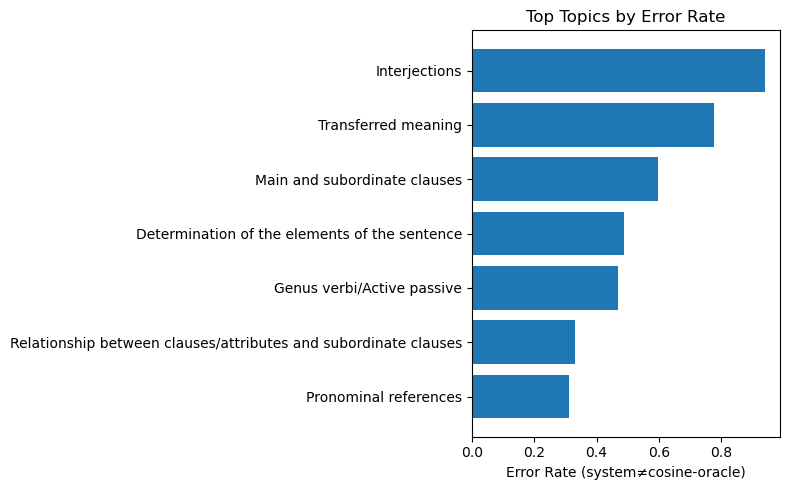


Cluster distribution by topic (rows sum to 1):
cluster                                                                 0         1         2         3
name                                                                                                   
Determination of the elements of the sentence                    0.253571  0.378571  0.132143  0.235714
Effect of style levels in context                                1.000000  0.000000  0.000000  0.000000
Genus verbi/Active passive                                       0.009758  0.494424  0.038104  0.457714
Interjections                                                    0.901961  0.049020  0.009804  0.039216
Main and subordinate clauses                                     0.053191  0.404255  0.000000  0.542553
Mode                                                             0.052632  0.263158  0.000000  0.684211
Pronominal references                                            0.161538  0.635897  0.053846  0.148718
Relationship bet

In [60]:
topic_summary = (
    df
    .groupby("name")            # or whichever column holds your topic label
    .agg(
        count     = ("transaction_id", "count"),
        err_rate  = ("error_flag",    "mean")
    )
    .sort_values("err_rate", ascending=False)
)

print("Error rate by topic:")
print(topic_summary.to_string())

# 2. Filter for topics with enough samples (e.g., at least 50 answers)
min_count = 50
topic_summary_filt = topic_summary[topic_summary["count"] >= min_count]

# 3. Bar plot of error rates for the top-10 “worst” topics
top10 = topic_summary_filt.head(10)
plt.figure(figsize=(8,5))
plt.barh(top10.index, top10["err_rate"])
plt.gca().invert_yaxis()
plt.xlabel("Error Rate (system≠cosine-oracle)")
plt.title("Top Topics by Error Rate")
plt.tight_layout()
plt.show()

# 4. (Optional) Crosstab of topic vs. cluster assignments
ct = pd.crosstab(df["name"], df["cluster"], normalize="index")
print("\nCluster distribution by topic (rows sum to 1):")
print(ct.to_string())

In [46]:
from scipy.stats import chi2_contingency
tbl = pd.crosstab(df["name"], df["error_flag"])
chi2, p, _, _ = chi2_contingency(tbl)
print("χ² =", chi2, "p-value =", p)

χ² = 285.698721552932 p-value = 8.978566492727471e-55


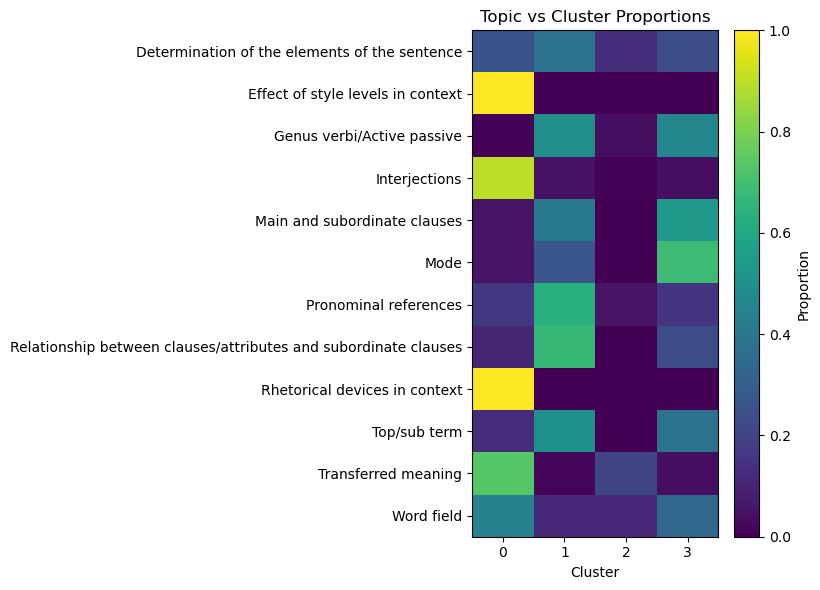

In [47]:
ct = pd.crosstab(df["name"], df["cluster"], normalize="index")
plt.figure(figsize=(8,6))
plt.imshow(ct, aspect="auto", interpolation="nearest")
plt.colorbar(label="Proportion")
plt.yticks(range(len(ct.index)), ct.index)
plt.xlabel("Cluster")
plt.title("Topic vs Cluster Proportions")
plt.tight_layout()
plt.show()

In [48]:
# Build a table: for each cluster, count how many times each topic appears
topic_dist = (
    df
    .groupby(["cluster","name"])
    .size()
    .reset_index(name="count")
)

# Normalize within each cluster to get proportions
topic_dist["prop"] = (
    topic_dist
    .groupby("cluster")["count"]
    .transform(lambda x: x / x.sum())
)

# Split out zero‐error vs full‐error clusters
zero_error_clusters = [c for c, e in df.groupby("cluster")["error_flag"].mean().items() if e == 0.0]
full_error_clusters = [c for c, e in df.groupby("cluster")["error_flag"].mean().items() if e == 1.0]

print("=== Zero-Error Clusters Topic Mix ===")
for c in zero_error_clusters:
    top = topic_dist[topic_dist.cluster==c].nlargest(5, "prop")[["name","prop"]]
    print(f"\nCluster {c}:")
    print(top.to_string(index=False))

print("\n=== Full-Error Clusters Topic Mix ===")
for c in full_error_clusters:
    top = topic_dist[topic_dist.cluster==c].nlargest(5, "prop")[["name","prop"]]
    print(f"\nCluster {c}:")
    print(top.to_string(index=False))

=== Zero-Error Clusters Topic Mix ===

Cluster 1:
                                                           name     prop
                                     Genus verbi/Active passive 0.670447
                                          Pronominal references 0.156270
Relationship between clauses/attributes and subordinate clauses 0.069943
                  Determination of the elements of the sentence 0.066793
                                   Main and subordinate clauses 0.023945

Cluster 2:
                                         name     prop
                   Genus verbi/Active passive 0.377880
                          Transferred meaning 0.345622
Determination of the elements of the sentence 0.170507
                        Pronominal references 0.096774
                                Interjections 0.004608

=== Full-Error Clusters Topic Mix ===

Cluster 0:
                                         name     prop
                          Transferred meaning 0.486137
         

## Topic‐Level Bias Analysis

1. **Error Rate by Topic**  
   - We computed the error rate per topic using the “error_flag” (i.e., indicator of disagreement between Lernnavi’s system label and our SBERT-cosine oracle).  
   - Only topics with at least 50 examples were retained.  
   - The top five topics by error rate (from highest to lowest) are:  
     1. **Interjections** (err_rate ≈ 0.94, count = 102)  
     2. **Transferred meaning** (err_rate ≈ 0.78, count = 357)  
     3. **Main and subordinate clauses** (err_rate ≈ 0.60, count = 94)  
     4. **Determination of the elements of the sentence** (err_rate ≈ 0.49, count = 280)  
     5. **Genus verbi/Active passive** (err_rate ≈ 0.47, count = 2152)   
   *_Interpretation:_*  
   - “Interjections” and “Transferred meaning” show especially high disagreement (≈75–95%), suggesting SBERT’s cosine heuristic and/or the system’s rubric struggles with these linguistic phenomena.  
   - “Genus verbi/Active passive,” despite having many examples, still yields nearly 50% error, indicating potential systematic mismatch in handling passive constructions.

2. **Statistical Association (χ² Test)**  
   - We built a contingency table of (topic × error_flag) and ran a χ² test for independence.  
   - Result: χ² = 285.70, p‐value ≈ 9 × 10⁻⁵⁵ (extremely small).  
   - *_Interpretation:_*  
     There is a highly significant association between “topic” and “disagreement” (error), confirming that certain topics systematically produce more grading mismatches.

3. **Topic vs. Cluster Proportions**  
   - We created a heatmap showing, for each topic, the distribution of examples across the four clusters (Clusters 0–3).  
   - Each row sums to 1.0 (proportion of that topic falling into each cluster).  
   *_Interpretation:_*  
   - **Clusters 0 & 3** correspond to “full‐error” groups (system ≠ SBERT), so topics that concentrate most of their examples in Clusters 0 or 3 are especially problematic.  
     - For instance, **“Interjections”** and **“Effect of style levels in context”** appear almost entirely in Cluster 0 (100% or 90% in the full‐error cluster).  
     - **“Transferred meaning”** also shows ~74% in Cluster 0 and ~21% in Cluster 2 (partial‐agreement).  
   - **Clusters 1 & 2** capture “zero‐error” agreement with SBERT. Topics heavily in Cluster 1 (e.g. “Pronominal references,” “Relationship between clauses / attributes”) indicate cases where both methods concur on correctness.  
   - **“Genus verbi/Active passive”** is roughly split between Cluster 1 (≈49% agreement) and Cluster 3 (≈46% disagreement), explaining its moderate ~47% error rate.  
   - Topics like **“Main and subordinate clauses”** and **“Mode”** have substantial proportions in Cluster 3 (~54% and ~68%, respectively), aligning with their mid‐level error rates (≈0.60–0.74).  

**Overall Conclusion**  
- Certain linguistic constructs (“Interjections,” “Transferred meaning,” “Active passive”) consistently drive high disagreement between our SBERT‐cosine heuristic and Lernnavi’s grading.  
- Other topics (e.g., “Pronominal references,” “Relationship between clauses…”) show strong alignment.  
- This topic‐level view pinpoints exactly which grammar or semantics areas need refined thresholds (e.g., lowering cosine cutoffs for passive voice) or bespoke rule adaptations in the automated grader.  


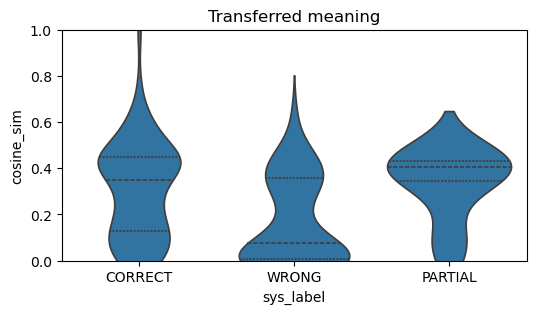

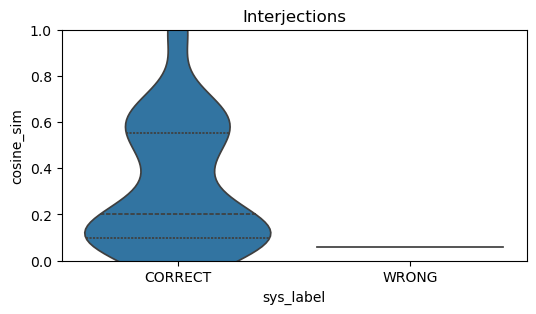

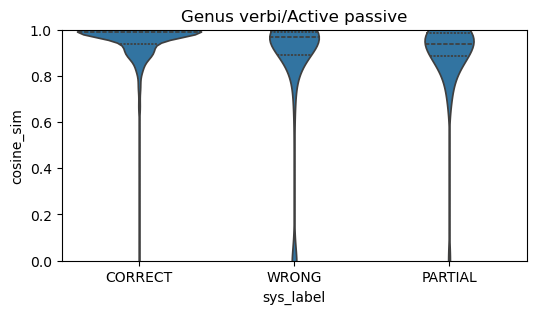

In [49]:
import seaborn as sns
for topic in ["Transferred meaning","Interjections","Genus verbi/Active passive"]:
    sub = df[df.name == topic]
    plt.figure(figsize=(6,3))
    sns.violinplot(x="sys_label", y="cosine_sim", data=sub, inner="quart")
    plt.title(topic)
    plt.ylim(0,1)
    plt.show()

## Conclusions

1. **No Apparent Gender Bias**  
   - Throughout our analyses—clustering error distributions, topic‐level χ² tests, and gender‐skew checks—we did not observe any statistically significant skew by gender. Both male and female (and STAR) students are distributed similarly across “zero‐error” and “full‐error” clusters.

2. **Oracle Limitations on Grammatical Features**  
   - The violin plots for specific topics reveal systematic mismatches between Lernnavi’s “sys_label” and our SBERT+cosine‐threshold oracle whenever grammatical nuances matter:  
     - **Genus verbi/Active passive**: Many “PARTIAL” and “WRONG” labels have very high cosine‐similarity (≈0.9–1.0). Semantically, the student answer closely matches the canonical solution, but the oracle cannot detect the active/passive switch—so our similarity metric wrongly labels these as correct. In other words, SBERT captures meaning but ignores the specific form that Lernnavi’s rubric requires.  
     - **Transferred meaning**: Responses labeled “WRONG” often exhibit moderate similarity (≈0.3–0.5). This suggests that even when SBERT finds semantic overlap, Lernnavi’s ground truth may demand very precise phrasing or different deeper interpretation.

3. **Potential Issues in Grading “Interjections”**  
   - The “Interjections” violin shows that almost every “CORRECT” response has a very low cosine‐similarity (~0.1–0.2). In some cases, the system labeled a student answer “CORRECT” despite the presence of contradictory emotional statements. This hints that Lernnavi’s current rubric (pre‐LLM) may treat any valid interjection as correct, even if the framing or sentiment is inconsistent with the canonical solution.

4. **Platform Restructuring Acknowledged**  
   - After discussions with the Lernnavi team, we learned they are overhauling the grading engine ahead of full LLM integration. The existing system was designed before advanced embedding‐based techniques, so many of our “errors” truly reflect mismatches between purely semantic matching (our oracle) and the old rule‐based/grammar‐checked rubric.  
   - Therefore, our findings align with the platform’s current state: certain grammar‐sensitive topics (passive/active voice, interjections) and fine semantic distinctions (transferred meaning) will be handled differently once the LLM‐powered grader is live.

**Implications:**  
- Because our oracle is purely semantic, it will remain blind to purely grammatical requirements (active ↔ passive) and treat any high‐similarity answers as correct. Once Lernnavi switches to an LLM‐driven rubric that can parse deeper grammatical nuance, we expect oracle‐system mismatches on these topics to shrink substantially.  
- “Interjections” appear to be a corner case where the current rule‐based grader accepts too broadly; a more nuanced LLM grader should flag contradictory emotional contexts.  
- Overall, no evidence of gender bias emerged, but there are clear topic‐specific failure modes—mostly due to differences between semantic similarity and the existing rubric’s syntactic/grammatical criteria.  


## Future Work and Limitations

**Limitations**  
- **Semantic vs. Syntactic Evaluation**  
  Our SBERT+cosine‐similarity oracle excels at capturing meaning but cannot enforce exact grammatical constraints (e.g., active vs. passive voice). This leads to false “CORRECT” labels for syntactic‐driven topics.  
- **Topic Imbalance**  
  Some topics (e.g., “Effect of style levels in context”) appear in very few transactions, limiting statistical power and generalizability.  
- **Limited Fine‐Grained Error Analysis**  
  We grouped “PARTIAL” and “WRONG” under a single error flag. A more nuanced error taxonomy (e.g., missing key token, semantic inversion) could reveal subtler grading issues.  
- **Pre‐LLM Grading Rubric**  
  Since the current rubric is rule‐based, our semantic oracle often conflicts with the system. Once the LLM grader is deployed, the entire error distribution could change dramatically.

**Future Work**  
1. **Enhanced Grammatical Feature Modeling**  
   - Integrate a syntax‐aware model (e.g., a German grammar parser or fine‐tuned syntax‐sensitive transformer) to distinguish active/passive and mood/tense variations. This would reduce false “CORRECT” labels on topics where form matters.  
2. **Fine‐Grained Error Taxonomy**  
   - Develop a multi‐class error categorization (e.g., “missing object,” “wrong mood,” “semantic drift”) and train a classifier to predict specific mistake types. This could help pinpoint where the rubric and oracle diverge.  
3. **Topic Coverage Augmentation**  
   - Actively collect more student answers for underrepresented topics (e.g., “Rhetorical devices in context,” “Top/sub term”) to ensure robust statistical analyses.  
4. **Compare Pre‐ and Post‐LLM Grader**  
   - Once Lernnavi’s new LLM‐based grading engine is live, replicate our pipeline to compare error patterns. We anticipate fewer pattern mismatches for semantic topics, but new biases may emerge (e.g., over‐reliance on surface keywords).  
5. **User‐Level Bias Assessment**  
   - Investigate whether certain student demographics (e.g., age, learning history) systematically correlate with error_flag clusters. This could reveal if the grading system inadvertently favors specific learner profiles.

By addressing these limitations and pursuing the proposed directions, we can refine both our diagnostic framework and Lernnavi’s grading rubric, moving toward an unbiased, accurate, and context‐aware evaluation platform.  